# Class Imbalance Problem

In [ ]:
# # Importing function to split data into training and testing sets
# from sklearn.model_selection import train_test_split

# # Importing Logistic Regression model for binary or multi-class classification
# from sklearn.linear_model import LogisticRegression

# # Importing Random Forest classifier, an ensemble learning method for classification
# from sklearn.ensemble import RandomForestClassifier

# # Importing evaluation metrics for classification tasks:
# # - classification_report: Generates a summary of precision, recall, F1-score, etc.
# # - confusion_matrix: Computes a confusion matrix to evaluate the classification results.
# # - precision_recall_curve: Computes the precision-recall curve, useful for imbalanced datasets.
# # - average_precision_score: Computes the average precision score, also useful for imbalanced datasets.
# from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_curve, average_precision_score)

# # Importing SMOTE (Synthetic Minority Over-sampling Technique) for handling imbalanced datasets by oversampling the minority class
# from imblearn.over_sampling import SMOTE

# # Importing RandomUnderSampler for handling imbalanced datasets by undersampling the majority class
# from imblearn.under_sampling import RandomUnderSampler

# # Importing Pipeline from imbalanced-learn to create a pipeline that combines resampling and classification models
# from imblearn.pipeline import Pipeline

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_curve, average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Charger les données
data = pd.read_csv('machine_failure_dataset.csv')

### Illustration du problème de déséquilibre

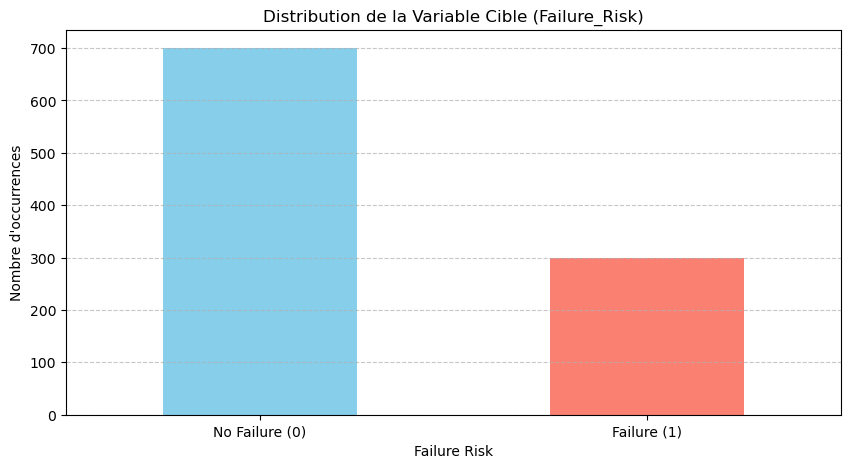

In [28]:
plt.figure(figsize=(10, 5))
data['Failure_Risk'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution de la Variable Cible (Failure_Risk)')
plt.xlabel('Failure Risk')
plt.ylabel('Nombre d\'occurrences')
plt.xticks([0, 1], ['No Failure (0)', 'Failure (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import seaborn as sns

# Préparation des données
X = pd.get_dummies(data.drop('Failure_Risk', axis=1), columns=['Machine_Type'])
y = data['Failure_Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fonction pour entraîner et évaluer
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    return model, y_pred, y_proba

# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr_model, lr_pred, lr_proba = train_evaluate_model(lr, X_train, y_train, X_test, y_test)

Text(0.5, 1.0, 'Distribution des probabilités prédites de Failure_Risk')

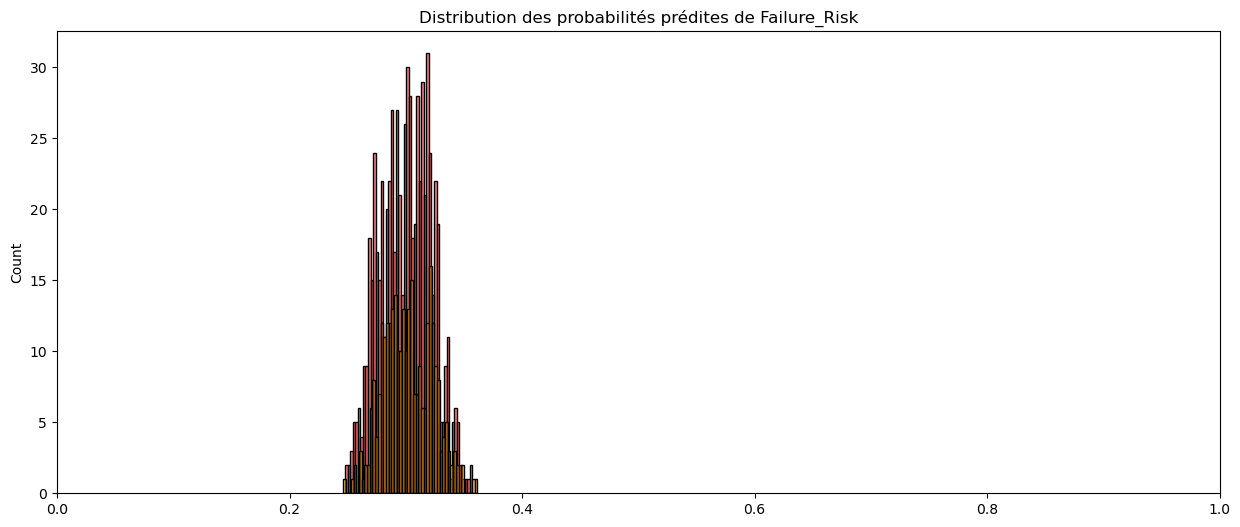

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(lr.predict_proba(X_train)[:, 1], bins=50, ax=ax, color='red', alpha=0.5, label='Train')
sns.histplot(lr.predict_proba(X_test)[:, 1], bins=50, ax=ax, color='orange', alpha=0.5, label='Test')
ax.set_xlim(0, 1)
plt.title('Distribution des probabilités prédites de Failure_Risk')

Text(0.5, 1.0, 'Distribution des probabilités prédites de Failure_Risk')

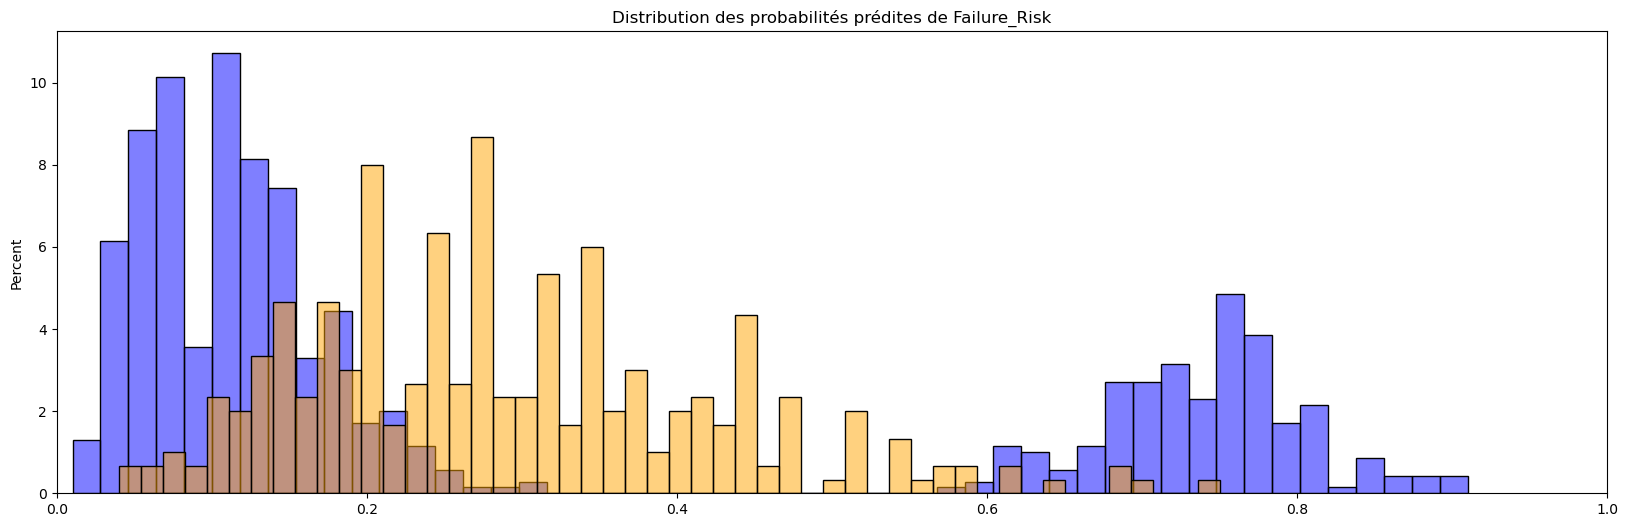

In [22]:
# 2. Random Forest

rf = RandomForestClassifier(random_state=42)
rf_model, rf_pred, rf_proba = train_evaluate_model(rf, X_train, y_train, X_test, y_test)
fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(rf.predict_proba(X_train)[:, 1], stat="percent" , bins=50, ax=ax, color='blue', alpha=0.5, label='Train')
sns.histplot(rf.predict_proba(X_test)[:, 1], stat="percent", bins=50, ax=ax, color='orange', alpha=0.5, label='Test')
ax.set_xlim(0, 1)
plt.title('Distribution des probabilités prédites de Failure_Risk')

# Techniques au Moment de l'Entraînement (Training Time Techniques)

### 1. Random Under-Sampling


=== Random Forest avec Under-Sampling ===


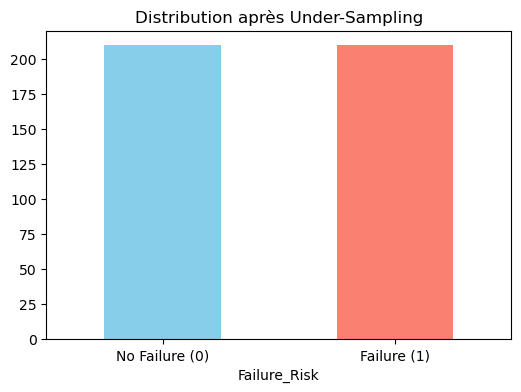

In [23]:
# Under-Sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print("\n=== Random Forest avec Under-Sampling ===")
rf_rus, rf_rus_pred, rf_rus_proba = train_evaluate_model(
    RandomForestClassifier(random_state=42), 
    X_train_rus, y_train_rus, X_test, y_test
)

# Visualisation de la nouvelle distribution
plt.figure(figsize=(6, 4))
pd.Series(y_train_rus).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution après Under-Sampling')
plt.xticks([0, 1], ['No Failure (0)', 'Failure (1)'], rotation=0)
plt.show()

### 2. SMOTE


=== Random Forest avec SMOTE ===


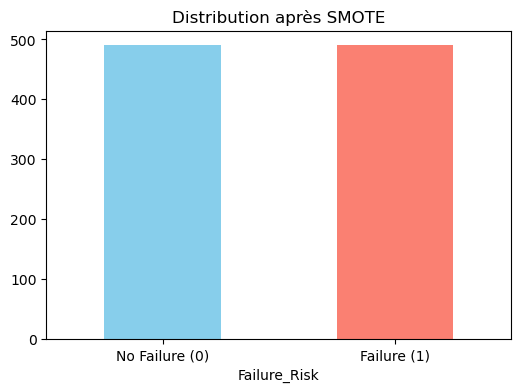

In [24]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n=== Random Forest avec SMOTE ===")
rf_smote, rf_smote_pred, rf_smote_proba = train_evaluate_model(
    RandomForestClassifier(random_state=42),
    X_train_smote, y_train_smote, X_test, y_test
)

# Visualisation de la nouvelle distribution
plt.figure(figsize=(6, 4))
pd.Series(y_train_smote).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution après SMOTE')
plt.xticks([0, 1], ['No Failure (0)', 'Failure (1)'], rotation=0)
plt.show()

# Technique au Moment de l'Inférence (Inference Time Technique)

### Precision-Recall Thresholding

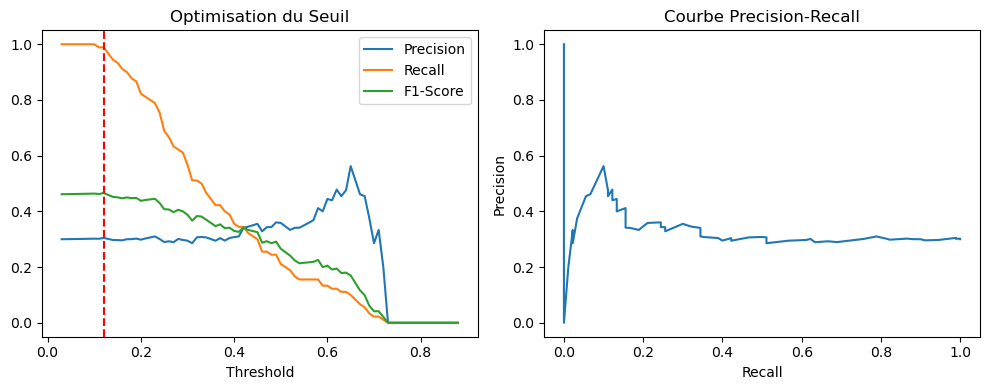

In [25]:
# Optimisation du seuil avec Precision-Recall
def optimize_threshold(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    
    # Trouver le seuil qui maximise F1-Score
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Adding a small value to avoid division by zero
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Visualisation
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.plot(thresholds, f1_scores[:-1], label='F1-Score')
    plt.axvline(optimal_threshold, color='red', linestyle='--')
    plt.xlabel('Threshold')
    plt.title('Optimisation du Seuil')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Courbe Precision-Recall')
    
    plt.tight_layout()
    plt.show()
    
    return optimal_threshold

# Application sur le modèle SMOTE
optimal_threshold = optimize_threshold(rf_smote, X_test, y_test)

# Prédiction avec le nouveau seuil
y_pred_optimal = (rf_smote.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

### Comparaison Complète des Techniques

c:\Users\elidrissi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elidrissi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elidrissi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


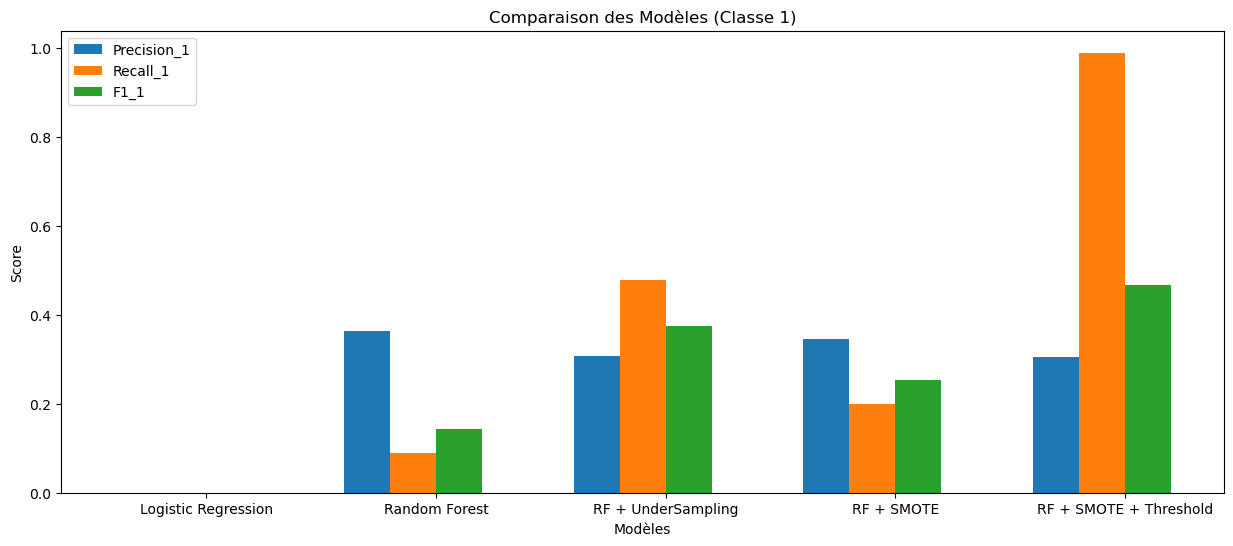

In [26]:
# Préparation des données pour comparaison
results = []
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'RF + UnderSampling': rf_rus,
    'RF + SMOTE': rf_smote,
    'RF + SMOTE + Threshold': None  # Spécial
}

for name, model in models.items():
    if name == 'RF + SMOTE + Threshold':
        y_pred = y_pred_optimal
        y_proba = rf_smote.predict_proba(X_test)[:,1]
    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'Model': name,
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'F1_0': report['0']['f1-score'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
        'F1_1': report['1']['f1-score'],
    })

results_df = pd.DataFrame(results)

# Visualisation comparative
plt.figure(figsize=(15, 6))
metrics = ['Precision_1', 'Recall_1', 'F1_1']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, results_df[metric], width, label=metric)

plt.xlabel('Modèles')
plt.ylabel('Score')
plt.title('Comparaison des Modèles (Classe 1)')
plt.xticks(x + width*1.5, results_df['Model'])
plt.legend()
plt.show()